# Generating Simpsons Scenes from sketches using a pix2pix model

In this Notebook, we will use the [Simpsons dataset](https://www.kaggle.com/alexattia/the-simpsons-characters-dataset/) to train a pix2pix model to generate Simpsons scenes from simple drawings. 

The pix2pix allows to build generative models conditioned on spatial inputs (i.e. images)

paper:
* [pix2pix](https://arxiv.org/abs/1611.07004)

In [1]:
import scipy
import numpy as np
import cv2
import os
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from viz import updatable_display2
import seaborn as sns

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets

use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

## The Data

number of images: 20933


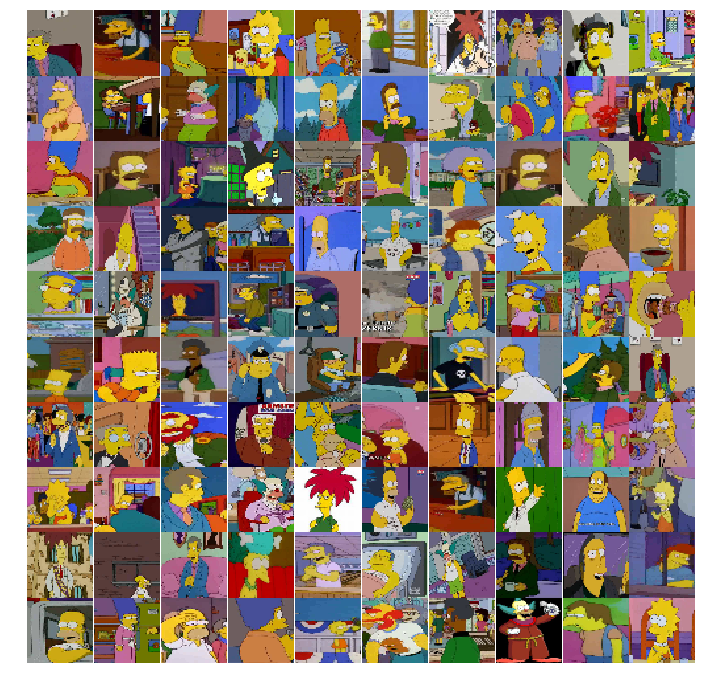

In [2]:
root = "/scratch/simpsons/simpsons_dataset" # path where the data was extracted

def getPaths(root):
    for sub_dir in os.listdir(root):
        sub_path = os.path.join(root,sub_dir)
        for file in os.listdir(sub_path):
            if 'jpg' in file:
                yield(os.path.join(sub_path,file))
def readimg(l):
    im = cv2.imread(l)
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
            
paths = list(getPaths(root))
print("number of images:", len(paths))

i_ = 0
plt.figure(figsize=(12, 12)) 
plt.subplots_adjust(wspace=0, hspace=0)
for l in np.random.choice(paths,100):
    im = readimg(l)
    im = cv2.resize(im, (50, 50)) 
    plt.subplot(10, 10, i_+1) #.set_title(l)
    plt.imshow(im); plt.axis('off')
    i_ += 1

In [3]:
#shapes = set([scipy.ndimage.imread(p).shape for p in paths])
#heights = [s[0] for s in shapes]
#widths = [s[1] for s in shapes]
#plt.title("height and widths distribution")
#sns.distplot(heights)
#sns.distplot(widths)
#plt.show()

### Resizing the data

We need to resize the data into the same format for our generative model

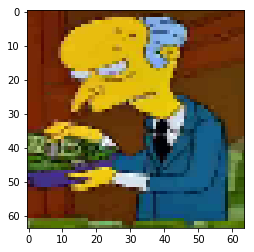

In [4]:
IMG_SIZE = 64
def resize(img):
    return cv2.resize(img, (IMG_SIZE, IMG_SIZE)) 

plt.imshow(resize(readimg(paths[999])))

### Edge Extraction

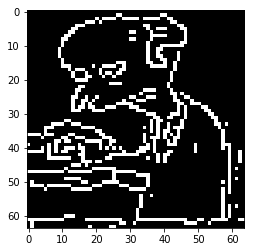

In [5]:
def edgeExtract(img):
    return cv2.Canny(img,300,300)
img = resize(readimg(paths[999]))
edges = edgeExtract(img)
plt.imshow(edges,cmap='gray')

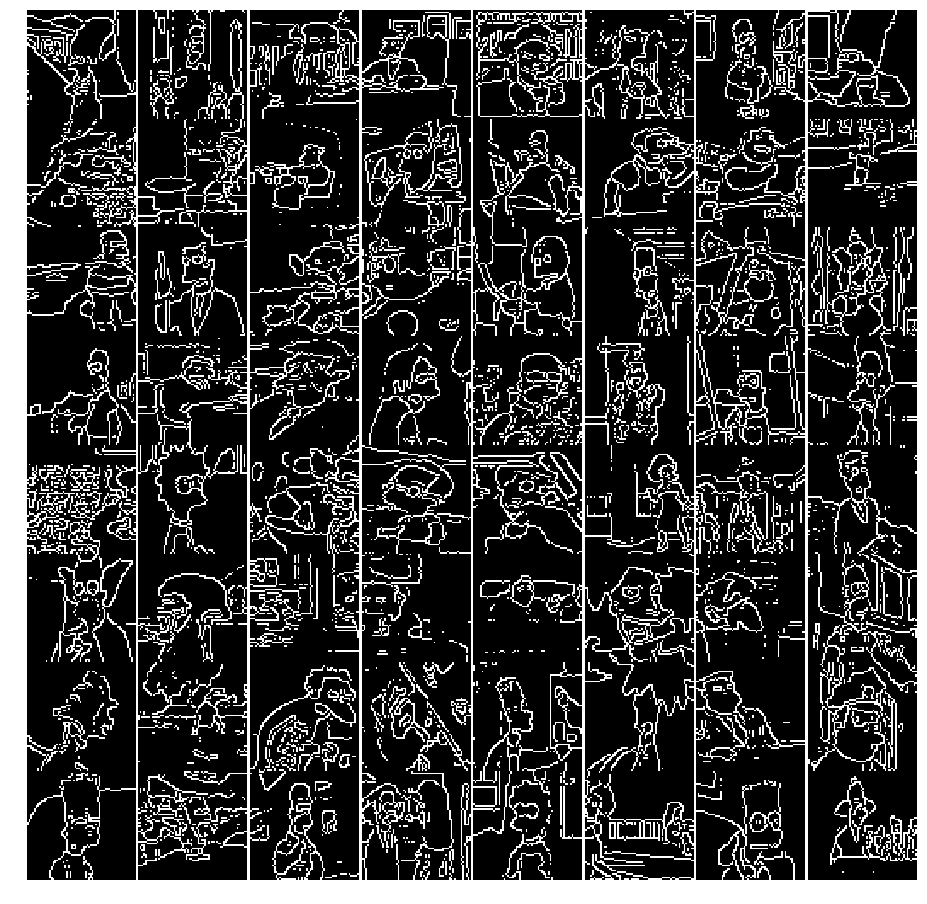

In [6]:
m = 8
i_ = 0
plt.figure(figsize=(16, 16)) 
plt.subplots_adjust(wspace=0, hspace=0)
for l in np.random.choice(paths,m**2):
    im = resize(readimg(l))
    im = edgeExtract(im)
    plt.subplot(m, m, i_+1) #.set_title(l)
    plt.imshow(im, cmap="gray"); plt.axis('off')
    i_ += 1

### Pytorch Dataset

In [10]:
import scipy
import numpy as np
import cv2
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

def getPaths(root):
    for sub_dir in os.listdir(root):
        sub_path = os.path.join(root,sub_dir)
        for file in os.listdir(sub_path):
            if 'jpg' in file:
                yield(os.path.join(sub_path,file))
def readimg(l):
    im = cv2.imread(l)
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

def resize(img,size):
    return cv2.resize(img, (size, size)) 

def edgeExtract(img):
    edges =  cv2.Canny(img,300,300)
    #edges = cv2.dilate(edges,kernel = np.ones((5,5),np.uint8),iterations = 1)
    return edges 

class Simpsons(Dataset):
    """Simpsons dataset."""
    def __init__(self, root_dir, size, transform = None, hole_size=0, n_holes = 0):
        
        def randomHoles(x):
            r = hole_size
            for _ in range(n_holes):
                i = np.random.choice(range(x.shape[0]-r))
                j = np.random.choice(range(x.shape[1]-r))
                x[i:i+r,j:j+r] = 0
            return x
        
        self.paths = list(getPaths(root_dir))
        self.size = size
        self.img_transform = transforms.Compose([
                   transforms.ToTensor(),
                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
               ])
        self.edge_transforms = transforms.Compose([
                   transforms.Lambda(randomHoles),
                   transforms.ToTensor(),
               ])

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = resize(readimg(self.paths[idx]), self.size)
        return self.img_transform(img), self.edge_transforms(edgeExtract(img)[:,:,None])

In [12]:
dataset = Simpsons(root,64)
dataset[0][0].shape,dataset[0][1].shape

(torch.Size([3, 64, 64]), torch.Size([1, 64, 64]))

In [13]:
dataset[0][0].min(), dataset[0][0].max()

(tensor(-1.), tensor(1.))

## Model

The pix2pix model uses

* a U-Net model as generative model $G$. This model takes an image $y$ (or other 2D input) as input and produces another image $x$ (or other 2D input)
* a convolutional dscriminator model $D$. This model takes both $x$ and $y$ as input and tries to guess if $x \sim p_x$ or $x \sim p_G$

The model is trained using the GAN loss function and an additional $L_1$ loss on the output of the generative model $G$. Both losses are balanced using an additional hyperparameter $lambda$ (set to 100 in the original paper), the loss is:

$L = L_{GAN} + \lambda * L_1$


### Generator $G$

In [14]:
from network import Generator

### Discriminator $D$

In [15]:
from network import Discriminator

## Set Model

In [16]:
batch_size = 32
m_test = int(np.sqrt(batch_size))
m_test = m_test - 1 if m_test**2 > batch_size else m_test
lr = 6e-4
lambda_l1 = 100 # original paper value is 100

in_channels = 1
out_channels = 3
n_features_zero = 32
group_norm = 8
n_resblocks = 1
num_dilated_convs = 4
depth = 4
kernel_size = 3
padding = 1



def weights_init(m):
    if isinstance(m, nn.Conv2d): 
        if m.weight is not None:
            init.xavier_uniform_(m.weight)
        if m.bias is not None:
            init.constant_(m.bias, 0.0)
    elif isinstance(m, nn.Linear):
        if m.weight is not None:
            init.xavier_uniform_(m.weight)
        if m.bias is not None:
            init.constant_(m.bias, 0.0)
